## Manually Calculating Retention: The Way Of The Data Jedi

Retention is, without question, a top 5 KPI that is tracked for user analytics. Retention is a measure of how long your users or accounts stick around after they first join.

Retention is often higlighted in analytics tools as drag 'n drop. But have you ever wondered how it's calculated in the first place?

Learning to calculate retention manually is like chopping down your own tree before you turn it into a table. You won't need to do this all the time, but when you do, you'll be glad you had.

So let's wax on/wax off grasshopper and see how this is done...

**Goal: Calculate user retention for a fictional b2c app**

Steps:
1. Get the first day your users were active
2. Derive the week and month of that start date
3. For each remaining day of activity since the start date, find out the relative number of days between the day of activity and the user's start date.
4. Do the same for week and month
5. Plot how many users are 'left' via the relative time between activity and start date
6. Then split your plot into cohorts by isolating your users by when they first started

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

We are going to be working with a fictional dataset. Believe it or not, it look me a second to figure out the best way to create it. If you're interested in creating your own user retention data, [check it out here.](https://github.com/Data-Indepedent/pandas_everything/blob/master/pair_programming/Pair_Programming_7a_Creating_Retention_Dataset.ipynb)

In [2]:
df = pd.read_csv('../data/RetentionDataset.csv', parse_dates=['day'])
print("You have {} rows in your data".format(len(df)))
df.head()

You have 300777 rows in your data


,user_id,day,active
0,cc81d6ba-a4e6-45ff-952f-ce1ea212a50f,2020-01-20,1
1,a58cd768-1318-47f7-bea4-09982e6f5479,2020-01-26,1
2,5d6bb30f-b525-4860-9704-8d06e1a42bad,2020-01-03,1
3,5ce8faec-7390-47da-b861-c621bf7077d3,2020-01-26,1
4,2d7bdd44-0cc0-46b7-b247-4be58cfd327c,2020-01-05,1


As you can see above, what we have is a table with ~300K rows and three columns representing users, the day a user was active, and then an indicator column. The indicator column is all 1s (I filtered out the 0s) so it doesn't provide a lot of value other than making you feel better about your data.

Either way, the first step is finding in *the first day* your user was active. This will help you put your users into *cohorts* segmented by when they started.

### Derive when your user first started
This is pretty easy, just group by user_id and find the minimum date for each one

In [3]:
# Get the first day a user was active
start_date = df.groupby('user_id')['day'].min()
start_date = start_date.rename("start_day")
start_date.head()

user_id
0001143b-9583-4e9c-bcbf-958d5416bcc1   2020-07-07
00030b74-3f01-4ea7-9632-a58bfee36c46   2020-05-17
00039164-0c53-472b-b053-3bfbc3a12762   2020-06-23
000726bd-f312-4612-8ceb-4ca028dfb57c   2020-05-12
00090bcd-d7e9-470f-9d46-d80c81fa9d78   2020-04-17
Name: start_day, dtype: datetime64[ns]

See above, what we get is a table with 1 row per user, and the corresponding start date. The assumption here is that their first day of activity is their registration date or start date.

Then join that data back onto your original table. This will 'label' your users

In [4]:
# Join start date
df = pd.merge(df, start_date, left_on='user_id', right_index=True)
df.head()

,user_id,day,active,start_day
0,cc81d6ba-a4e6-45ff-952f-ce1ea212a50f,2020-01-20,1,2020-01-20
15114,cc81d6ba-a4e6-45ff-952f-ce1ea212a50f,2020-01-21,1,2020-01-20
25773,cc81d6ba-a4e6-45ff-952f-ce1ea212a50f,2020-01-22,1,2020-01-20
41779,cc81d6ba-a4e6-45ff-952f-ce1ea212a50f,2020-01-24,1,2020-01-20
71184,cc81d6ba-a4e6-45ff-952f-ce1ea212a50f,2020-01-29,1,2020-01-20


Next, for each row, calculate the days since start.

In [5]:
df['days_since_start'] = (df['day'] - df['start_day']).dt.days
df.head()

,user_id,day,active,start_day,days_since_start
0,cc81d6ba-a4e6-45ff-952f-ce1ea212a50f,2020-01-20,1,2020-01-20,0
15114,cc81d6ba-a4e6-45ff-952f-ce1ea212a50f,2020-01-21,1,2020-01-20,1
25773,cc81d6ba-a4e6-45ff-952f-ce1ea212a50f,2020-01-22,1,2020-01-20,2
41779,cc81d6ba-a4e6-45ff-952f-ce1ea212a50f,2020-01-24,1,2020-01-20,4
71184,cc81d6ba-a4e6-45ff-952f-ce1ea212a50f,2020-01-29,1,2020-01-20,9


This is a key point. Notice here that the 'days since start' show, for each day the user was active, how many days has it been since they first started.

We are doing this to get the relative retention for each user *since* their start date. This helps us understand what each user first day/week/month looks like.

Now that you have days since start, do the same thing for weeks and months since start. To make it each, make sure you have integers (no need to have floats).

In [6]:
# Extract start week
df['start_week'] = df.apply(lambda x: (x['start_day'] - pd.Timedelta(x['start_day'].dayofweek, u='day')).date(), axis=1)

# For some reason I don't care to dig into, the output was not a datetime so I'm converting it into one.
df['start_week'] = pd.to_datetime(df['start_week'])

# Get the number of weeks since the user started
df['weeks_since_start'] = np.floor((df['day'] - df['start_week']) / np.timedelta64(1, 'W'))

In [7]:
# Extract start month
df['start_month'] = df['start_day'].values.astype('datetime64[M]')

# Get the number of months since the user started
df['months_since_start'] = np.floor((df['day'] - df['start_month']) / np.timedelta64(1, 'M'))

Now let's check out our df and see what we have!

In [8]:
df.head()

,user_id,day,active,start_day,days_since_start,start_week,weeks_since_start,start_month,months_since_start
0,cc81d6ba-a4e6-45ff-952f-ce1ea212a50f,2020-01-20,1,2020-01-20,0,2020-01-20,0.0,2020-01-01,0.0
15114,cc81d6ba-a4e6-45ff-952f-ce1ea212a50f,2020-01-21,1,2020-01-20,1,2020-01-20,0.0,2020-01-01,0.0
25773,cc81d6ba-a4e6-45ff-952f-ce1ea212a50f,2020-01-22,1,2020-01-20,2,2020-01-20,0.0,2020-01-01,0.0
41779,cc81d6ba-a4e6-45ff-952f-ce1ea212a50f,2020-01-24,1,2020-01-20,4,2020-01-20,0.0,2020-01-01,0.0
71184,cc81d6ba-a4e6-45ff-952f-ce1ea212a50f,2020-01-29,1,2020-01-20,9,2020-01-20,1.0,2020-01-01,0.0


Let's plot the 40-day daily retention of *everyone* in the dataset. To do this, I want to make sure I only look at users with 40 days worth of data. I'm going to filter out everyone who started 40 days with my max date

In [9]:
f1 = df['start_day'] < df['day'].max() - pd.Timedelta(days=40)
dff = df[f1]

In [10]:
len(dff)

300777

Great, looks like it was everyone, so this step wasn't needed. But as a data person, I like the assurance that my data is clean.

Now let's step through the calculation once together. First, I only care about a user, their relative active day. Each row below tells me that user X was active on Y days after their starting date.

In [11]:
df[['user_id', 'days_since_start']].head()

,user_id,days_since_start
0,cc81d6ba-a4e6-45ff-952f-ce1ea212a50f,0
15114,cc81d6ba-a4e6-45ff-952f-ce1ea212a50f,1
25773,cc81d6ba-a4e6-45ff-952f-ce1ea212a50f,2
41779,cc81d6ba-a4e6-45ff-952f-ce1ea212a50f,4
71184,cc81d6ba-a4e6-45ff-952f-ce1ea212a50f,9


To find out how many users were still active, let's say 40 days out, I'm going to *group by* days since start, and then count distinct on user ID. 

100% of users will be active on day 1, I wonder how many users have a day 2 entry...

If a user does *not* have a day 2 row, then this tells me they weren't active, and the rentention of the population should go down for this day. Let's see...

In [12]:
df.groupby('days_since_start')['user_id'].nunique().head()

days_since_start
0    15114
1    10659
2     8566
3     7440
4     6722
Name: user_id, dtype: int64

WOW! And with that, we've calculated that there are 15,114 users in the dataset, and only 10,659 were active on day two. This means that 29.4% of users dropped off on day two. This is super cool to find out. 

Last thing we'll do is divide the total number of users in the dataset. If we end up looking at cohorts of different sizes, we'll want to look at *percent of the population* that was retained rather than absolute numbers.

In [13]:
df.groupby('days_since_start')['user_id'].nunique().head() / df['user_id'].nunique()

days_since_start
0    1.000000
1    0.705240
2    0.566759
3    0.492259
4    0.444753
Name: user_id, dtype: float64

Let's plot this out for the entire cohort. I'll add labels and call outs for digestability.

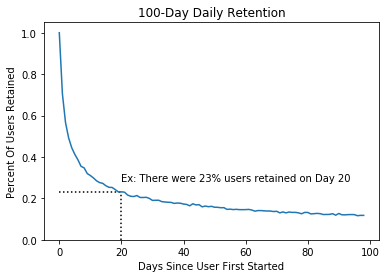

In [14]:
whole_retention = df.groupby('days_since_start')['user_id'].nunique() / df['user_id'].nunique()

plt.plot(whole_retention)
plt.title("100-Day Daily Retention")
plt.xlabel("Days Since User First Started")
plt.ylabel("Percent Of Users Retained")
plt.ylim(0,1.05)

plt.hlines(y=whole_retention.loc[20], xmin=0, xmax=20, linestyles='dotted')
plt.vlines(x=20, ymin=0, ymax=whole_retention.loc[20], linestyles='dotted')
plt.text(s=("Ex: There were {:.0%} users retained on Day 20".format(whole_retention.loc[20])),
        x=20, y=whole_retention.loc[20] + .05);

Wow that is cool! Now we can visually see users over their life on our service/app. I wonder if we are getting *better at retaining* users over time? Let's plot this same chart, but separate out the different user corhorts to see if things are improving and more users are sticking around.

There are more efficient ways to loop, but I'll do that one that speaks most like english, the trusty for loop.

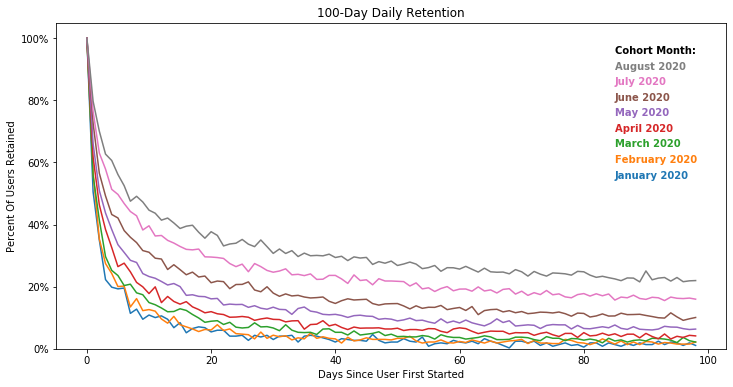

In [27]:
plt.figure(figsize=(12,6))
legend_x = 85
legend_y = .55

# For each start month you have, loop.
for i, month in enumerate(df['start_month'].unique()):
    
    # For each month, create a cohort df (dfc) that is filtered just for that month
    dfc = df[df['start_month']==pd.to_datetime(month)]

    # Then get your retention corhorts for that start month
    retention_cohort = dfc.groupby('days_since_start')['user_id'].nunique() / dfc['user_id'].nunique()
    
    # Finally, plot out that corhort
    p = plt.plot(retention_cohort)
    
    # My hacky way to get a nice legend in here
    plt.text(s=pd.to_datetime(month).strftime('%B %Y'), c=p[0].get_color(),
             x=legend_x, y=legend_y + (.05 * i), weight='bold')

plt.text(s="Cohort Month:", x=legend_x, y=legend_y + (.05 * i) + .05, weight='bold')
plt.title("100-Day Daily Retention")
plt.xlabel("Days Since User First Started")
plt.ylabel("Percent Of Users Retained")
plt.ylim(0,1.05)
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]);

Awesome, congratulations on just manually calculating retention! Have fun.